In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [5]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    image = []
    label = []

    random_fake = np.random.choice(os.listdir(fake_img), 40000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 40000, replace=False)

    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(random_fake, desc='Fake Training Data'):
        data = cv2.imread(os.path.join(fake_img, path))
        image.append(data)
        label.append(0)

    for path in tqdm(random_real, desc='Real Training Data'):
        data = cv2.imread(os.path.join(real_img, path))
        image.append(data)
        label.append(1)

    print()
    # image augmantation
    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    gen_image = []
    gen_label = []
    gen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip = True,
    )
    gen.fit(image)

    for i, j in gen.flow(image, label, batch_size=200):
        gen_image.append(i)
        gen_label.append(j)
        if len(gen_image)%50==0:
            print(f'{len(gen_image)*200}/80000 augmented data generated.')
        if len(gen_image)==400:
            print('Data augmentation done')
            break
    image = np.concatenate(gen_image)
    label = np.array(gen_label).flatten()

    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    image = image/255.0

    state = np.random.get_state()
    np.random.shuffle(image)
    np.random.set_state(state)
    np.random.shuffle(label)
    print('\nShuffle training data done.\n')
    print(f'Total training data : {len(image)}')
    
    return image, label

In [6]:
def TestData():
    fake_path = r"archive\test\FAKE"
    real_path = r"archive\test\REAL"
    image = []
    label = []
    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(os.listdir(fake_path), desc='Fake Testing Data'):
        data = cv2.imread(os.path.join(fake_path, path))
        image.append(data)
        label.append(0)
    
    for path in tqdm(os.listdir(real_path), desc='Real Testing Data'):
        data = cv2.imread(os.path.join(real_path, path))
        image.append(data)
        label.append(1)

    image=np.array(image).reshape(-1, 32, 32, 3)
    image=image/255
    label=np.array(label)

    return image, label

In [7]:
def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [8]:
train_x, train_y = TrainData()


Real Training Data: 100%|██████████| 40000/40000 [03:54<00:00, 170.41it/s]



10000/80000 augmented data generated.
20000/80000 augmented data generated.
30000/80000 augmented data generated.
40000/80000 augmented data generated.
50000/80000 augmented data generated.
60000/80000 augmented data generated.
70000/80000 augmented data generated.
80000/80000 augmented data generated.
Data augmentation done

Shuffle training data done.

Total training data : 80000


In [9]:
test_x, test_y = TestData()

Real Testing Data: 100%|██████████| 10000/10000 [00:59<00:00, 169.20it/s]


In [10]:

model = CNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [11]:
def f1(actual,predict):
    predict_val = []
    for i in range(len(predict)):
        predict_val.append(np.round(predict[i]))
    return f1_score(actual,predict_val,average='weighted')

In [12]:
train_ac, train_loss = [], []
test_ac, test_loss = [], []
f1_sc = []

for epoch in range(1, 21):
    history = model.fit(train_x, train_y, epochs=1, batch_size=200)
    loss, ac = model.evaluate(test_x, test_y, batch_size=200)
    predict = model.predict(test_x, batch_size=200)
    f1_sc.append(f1(test_y,predict))
    train_loss.append(history.history['loss'])
    train_ac.append(history.history['accuracy'])
    test_loss.append(loss)
    test_ac.append(ac)
    print()

625/625 [==============================] - 3s 4ms/step

625/625 [==============================] - 3s 5ms/step

625/625 [==============================] - 3s 4ms/step

625/625 [==============================] - 2s 4ms/step

625/625 [==============================] - 2s 4ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 3s 4ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 3s 4ms/step

625/625 [==============================] - 3s 4ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 2s 3ms/step

625/625 [==============================] - 2s 4ms/step

625/625 [==============================] - 2s 4ms/step

625/625 [==============================] - 2s 3m

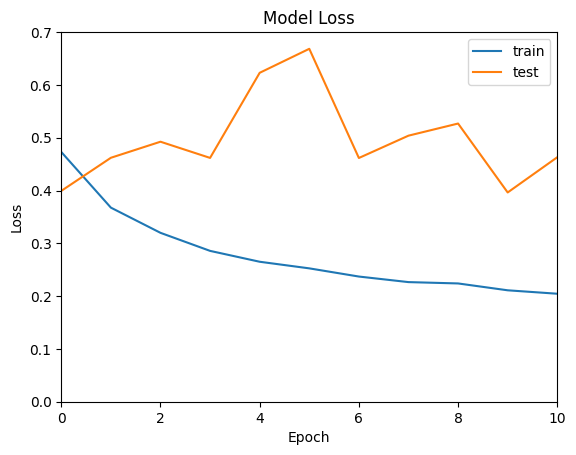

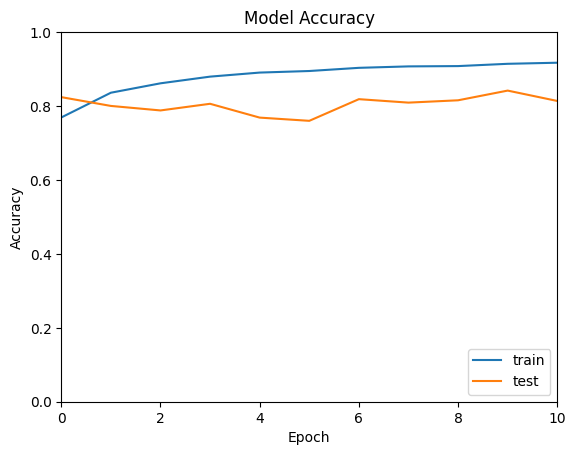

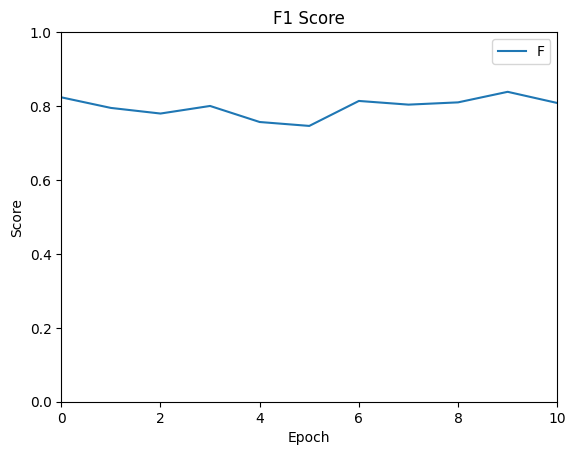

In [13]:
# Plot the loss and accuracy of training set.
plt.plot(train_loss)
plt.plot(test_loss)
plt.axis([0, 20, 0, 0.7])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(train_ac)
plt.plot(test_ac)
plt.axis([0, 20, 0, 1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(f1_sc)
plt.axis([0, 20, 0, 1])
plt.title('F1 Score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend('F1 Score')
plt.show()